## Distinguishing Bacterial and Viral Pneumonia: 3 Class Diagnostic  

### Caitlin Streamer

*Additional Materials:*   [GitHub](https://github.com/c-streams/Pneumonia) |   [Portfolio](https://caitlinstreamer.wordpress.com/portfolio/diagnosing-pediatric-pneumonia/) 

**Outline**
- [Introduction](#intro)
- [Import Images](#import)
- [Image Analysis](#EDA)
- [Image Processing](#process)
- [Data Augmentation](#aug)
- [Modeling](#model)
    - [CNN Model & Evaluation](#cnn)
    - [Transfer Learning VGG16 Model & Evaluation](#transfer)
    - [Transfer Learning InceptionV3 Model & Evaluation](#transfer_2)
- [Conclusions](#conc)
- [Next Steps](#next)
- [References](#ref)
------------------------------------

<a id='intro'></a>
### Introduction

Having successfully created CNN models to diagnose pediatric pneumonia from chest X-rays as a 2 class problem (normal vs pneumonia), I next extended it into a 3 class problem to distinguish normal cases from bacterial and viral pneumonia. Due to the differing treatments for bacterial and viral pneumonia, it is important to identify the cause of the condition and not just its presence. 

Fortunately I was able to utilize the same dataset, which has bacteria and virus labels for each pneumonia image. My methods were similar to the binary classifcation problem. I used the same image processing approach, performed similar image analysis, and compared a CNN model built from scratch to a transfer learning approach using both the VGG16 and InceptionV3 deep learning models trained on ImageNet [3]. 

<a id='import'></a>
### Import  Images  

Again, I import the images by defining their file directory path and creating a dataframe with their paths and assigned class label. 

In [1]:
# Import libraries

import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical 
from keras.applications import VGG16, InceptionV3
from keras.optimizers import Adam
import keras.backend as K
from sklearn.utils import resample
from sklearn import metrics

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


For the 3 class problem, I defined label = 0 as normal, label = 1 as bacterial pneumonia, and label = 2 as viral pneumonia. I created a modified import function to account for the additional class. 

In [2]:
# Function to create train and test dataframes composed of image URL and label 
def import_format(directory):
    # Define directory paths for the images 
    dir_normal_path = Path('data/'+ directory +'/NORMAL')
    dir_pne_path = Path('data/' + directory + '/PNEUMONIA')
    
    # Collect image paths from each directory 
    dir_normal = dir_normal_path.glob('*.jpeg')
    dir_pne_b = dir_pne_path.glob('*bacteria*.jpeg')
    dir_pne_v = dir_pne_path.glob('*virus*.jpeg')

    # Create list with the image paths and label (label = 0 NORMAL, label = 1 Bacterial, label = 2 Viral)
    dir_list = []
    for pic in dir_normal:
        dir_list.append((pic, 0))
    
    for pic in dir_pne_b:
        dir_list.append((pic, 1))
        
    for pic in dir_pne_v:
        dir_list.append((pic, 2))
        
    # Create dataframes from the train and test lists 
    df = pd.DataFrame(dir_list, columns = ['image_path', 'label'])
    
    # Shuffle dataframe so that the classes aren't in order
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [54]:
# Import and create train and test dataframes
test = import_format('test')
train = import_format('train')
train.head()

,image_path,label
0,data/train/PNEUMONIA/person929_virus_1588.jpeg,2
1,data/train/NORMAL/IM-0525-0001-0002.jpeg,0
2,data/train/PNEUMONIA/person94_virus_176.jpeg,2
3,data/train/PNEUMONIA/person1372_bacteria_3502....,1
4,data/train/NORMAL/NORMAL2-IM-1197-0001.jpeg,0


<a id='EDA'></a>
### Image Analysis 

From my prior analysis, I know that the images have 3 color channels and are of different sizes. What's now changed is the class balance. 

In [4]:
# Determine fraction of images in each class 
train['label'].value_counts()

1    2538
0    1349
2    1345
Name: label, dtype: int64

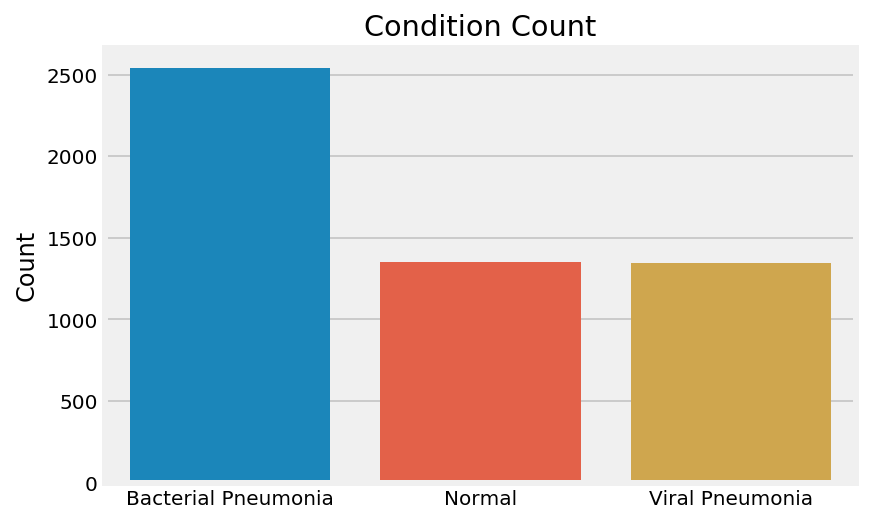

In [5]:
# Visualize class balance 
class_balance = train['label'].value_counts()
sns.barplot(['Bacterial Pneumonia','Normal', 'Viral Pneumonia'], class_balance)
plt.ylabel('Count')
plt.title('Condition Count');

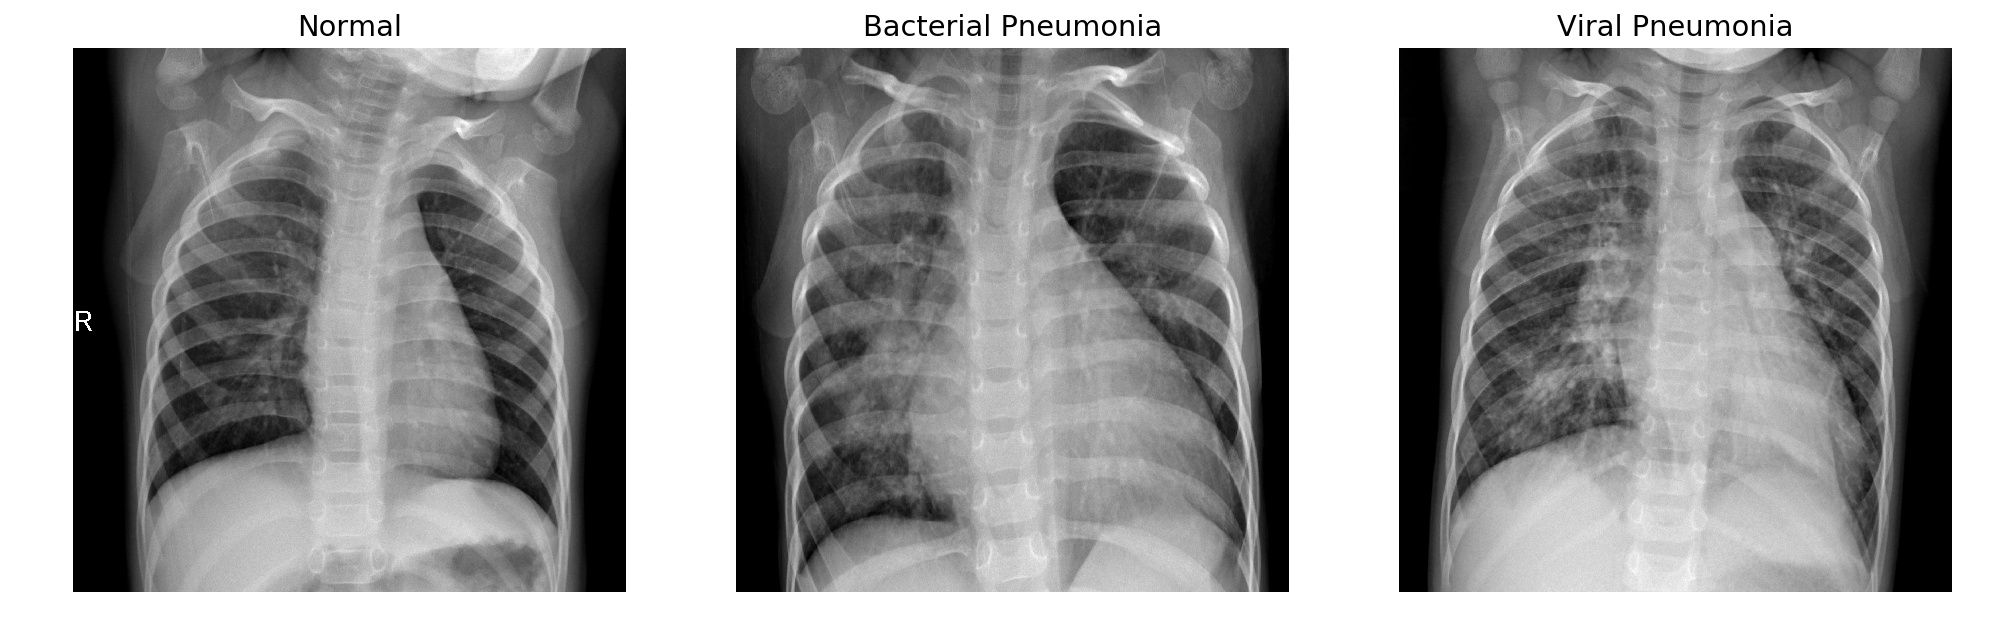

In [6]:
# Select one image from each class
normal = (train[train['label']==0]['image_path'].head(1)).tolist()
pneumonia_bact = (train[train['label']==1]['image_path'].head(1)).tolist()
pneumonia_viral = (train[train['label']==2]['image_path'].head(1)).tolist()

# Initiate plots 
fig, ax = plt.subplots(1,3, figsize = (15,5))

# Read images 
norm = imread(normal[0])
pne_b = imread((pneumonia_bact[0]))
pne_v = imread((pneumonia_viral[0]))
im = [norm, pne_b, pne_v]

for i in range(3): 
    # View images
    ax[i].imshow(im[i], cmap = 'gray')
    
    # Labels
    title = ['Normal', "Bacterial Pneumonia", "Viral Pneumonia"]
    ax[i].set_title(title[i])
    ax[i].axis('off')
    ax[i].set_aspect('auto');

From the untrained eye, it is not easy to distinguish the 3 different cases. 

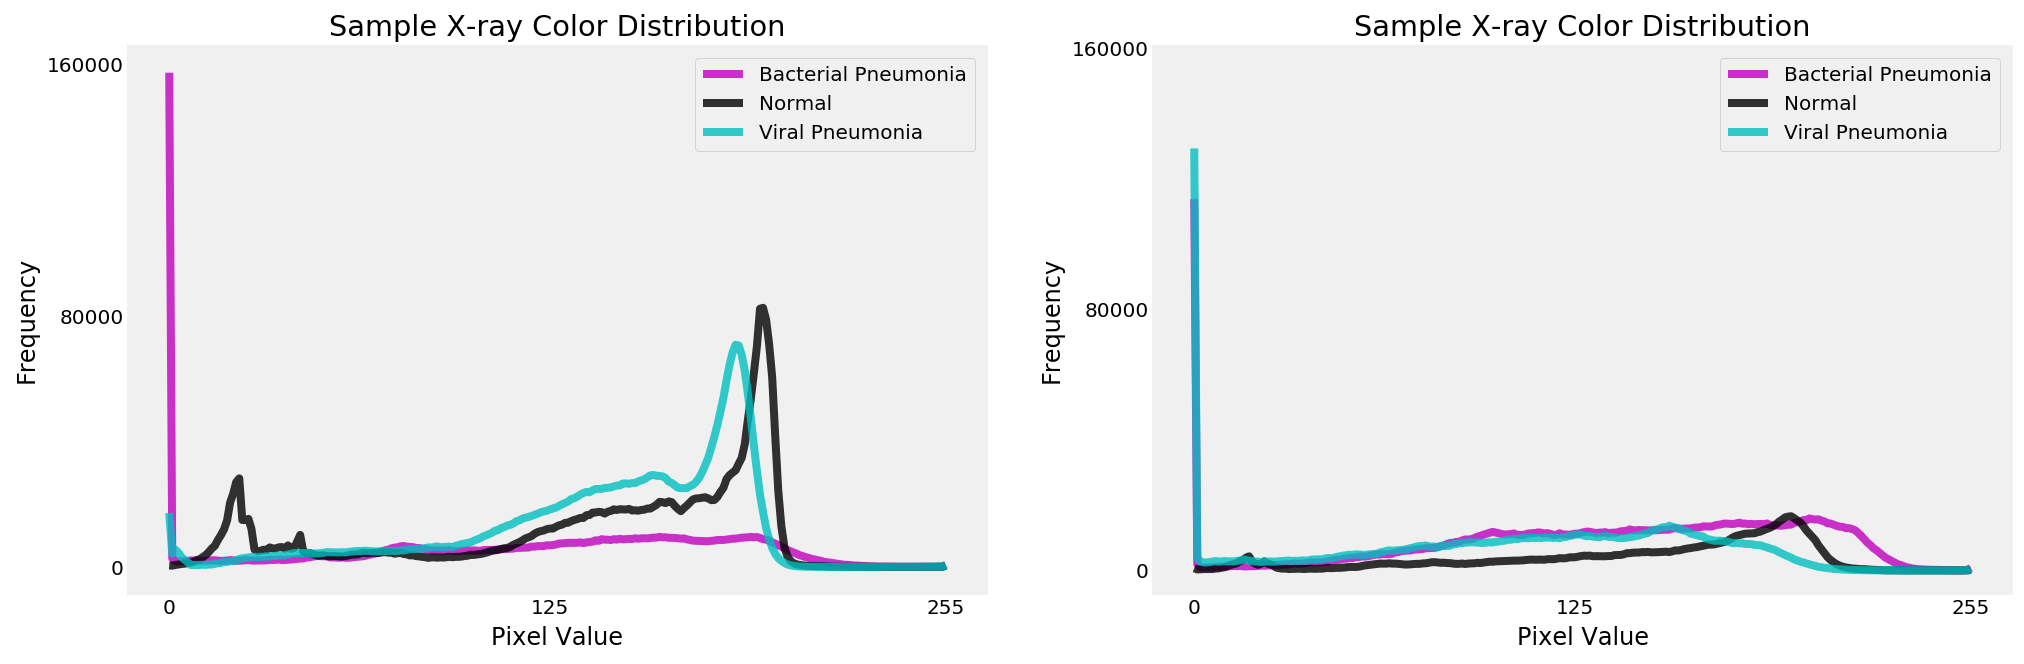

In [59]:
# Compare histograms of normal and pneumonia x-rays
fig, ax = plt.subplots(1,2, figsize = (15,5))

# Identify samples of each class
normal = (train[train['label']==0]['image_path'].head(10)).tolist()
pneumonia_bact = (train[train['label']==1]['image_path'].head(10)).tolist()
pneumonia_viral = (train[train['label']==2]['image_path'].head(10)).tolist()

# Read images
imgs = []
for i in range(2):
    imgs.append(cv2.imread(str(normal[i])))
    imgs.append(cv2.imread(str(pneumonia_bact[i])))
    imgs.append(cv2.imread(str(pneumonia_viral[i])))

# Calculate histograms
hists = []
for i in imgs:
    hists.append(cv2.calcHist([i],[2],None,[256],[0,256]))
    

# Plot histograms of images
count = 0
for i in range(2):
    ax[i].plot(hists[i + count],color = 'm', label = 'Bacterial Pneumonia', alpha = 0.8)
    ax[i].plot(hists[i + 1 + count], color = 'k', label = 'Normal', alpha = 0.8)
    ax[i].plot(hists[i + 2 + count], color = 'c', label = 'Viral Pneumonia', alpha = 0.8)
    count += 2

# Labels
for i in range(2):
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Pixel Value')
    ax[i].set_title('Sample X-ray Color Distribution')
    ax[i].legend(loc = 'best')
    ax[i].set_yticks([0,80000, 160000])
    ax[i].set_xticks([0, 125, 255])
    ax[i].grid(False);

Like before, there is no consistent pattern in the different cases color distributions. The peak at 0 (black) is consistent with X-rays. 

<a id='process'></a>
### Image Processing

I processed the images in the same way as my 2 class problem by resizing, converting fixel values to floats, and then scaling. I used the same processing function to accomplish this.  

I also balanced my classes to create and even class representation (33% / 33% / 33%) by oversampling with replacement from the 2 minority classes (normal and viral pneumonia). 

In [4]:
# Balance classes by oversampling - 33/33/33 split
# Isolate classes 
minority_1 = train[train['label'] == 0]
majority = train[train['label'] == 1] 
minority_2 = train[train['label'] == 2]

# Randomly oversample the 2 minority classes
balanced_minority_1 = resample(minority_1, replace = True, n_samples = 2538 , random_state = 42)
balanced_minority_2 = resample(minority_2, replace = True, n_samples = 2538 , random_state = 42)

# Combine oversampled dataframes and shuffle order
balanced = pd.concat([majority, balanced_minority_1, balanced_minority_2], axis = 0, ignore_index = True)
balanced = balanced.sample(frac=1).reset_index(drop=True)
balanced['label'].value_counts(normalize = True)

2    0.333333
1    0.333333
0    0.333333
Name: label, dtype: float64

In [5]:
# Define function to standardize image shape, covert back to RGB, and convert pixel values to floats
def processing(pic):
    pic = cv2.imread(str(pic))
    pic = cv2.resize(pic, (224,224))
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    pic = pic.astype(np.float32)/255
    return pic

In [6]:
# Define function to apply processing to test and train 
def train_test_processing(df_image_path, df_label, num_classes = 3):
    # Process images
    df_processed = df_image_path.map(lambda x: processing(x))
    
    # Convert df_processed into an array
    X = []
    for i in range(df_processed.shape[0]):
        X.append(df_processed[i])
    X = np.array(X)
    
    # Preprocess target label
    y = to_categorical(df_label, num_classes)
    
    return X, y

In [7]:
# Process test images
X_test, y_test = train_test_processing(test['image_path'], test['label'])

# Confirm shape
X_test.shape, y_test.shape

((624, 224, 224, 3), (624, 3))

In [8]:
# Process train images
X_train, y_train = train_test_processing(balanced['image_path'], balanced['label'])

# Confirm shape
X_train.shape, y_train.shape

((7614, 224, 224, 3), (7614, 3))

My X_test is composed of 624 images, each of shape 224 x 224 with 3 color channels (RGB). My X_train is now composed of 7614 images, each of shape 224 x 224 with 3 color channels (RGB). My targets can have 1 of 3 labels and the number of images matches the number of images in the train or test sets respectively.  

<a id='aug'></a>
### Data Augmentation

Similarly, I used the Keras ImageDataGenerator for data augmentation. I selected the same augmentation parameters for consistency. 

In [9]:
# Define data augmentation parameters 
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1) 

<a id='model'></a>
### Modeling

I built a newly trained convolutional neural network and evaluated its performance against a transfer learning approach with the Keras VGG16 and InceptionV3 deep learning models trained on ImageNet [3]. My network architecture was modified to optimize learning with an additional class. I modified the 3 evaluation functions I defined in the previous notebook to account for the multiclass scenario as well.  

The models were trained on an AWS Deep Learning AMI (Ubuntu 16.4) Version 11.0 GPU enabled computer with 4 virtual CPUs and 61 GiB memory. 

<a id='cnn'></a>
#### CNN Model & Evaluation

In order to combat overfitting, I kept my CNN architecture relatively simple with 2 convolution/pooling layers and a single dense output layer. Since I only have 5,000+ images to train on, I wanted to reduce the number of parameters as much as possible. Adding additional dense layers increased the number of parameters to train in the millions and resulted in very overfit models. I also incorportated dropout layers to reduce overfitting.

In [16]:
# Define CNN architecture 
model = Sequential()  

model.add(Conv2D(32,(3,3), input_shape = X_train.shape[1:], activation = 'relu'))
model.add(Conv2D(32,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add((Conv2D(64,(3,3), activation = 'relu')))
model.add((Conv2D(64,(3,3), activation = 'relu')))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(3, activation='softmax'))

# Compile 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# View summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 64)        0         
__________

In [17]:
# Fit model 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
238/238 [==============================] - 79s 333ms/step - loss: 0.9336 - acc: 0.5413 - val_loss: 0.8703 - val_acc: 0.6298
Epoch 2/20
238/238 [==============================] - 78s 326ms/step - loss: 0.6500 - acc: 0.6949 - val_loss: 0.9439 - val_acc: 0.6138
Epoch 3/20
238/238 [==============================] - 79s 333ms/step - loss: 0.5996 - acc: 0.7242 - val_loss: 0.9441 - val_acc: 0.6715
Epoch 4/20
238/238 [==============================] - 79s 331ms/step - loss: 0.5779 - acc: 0.7392 - val_loss: 0.8334 - val_acc: 0.6699
Epoch 5/20
238/238 [==============================] - 78s 328ms/step - loss: 0.5595 - acc: 0.7461 - val_loss: 0.8175 - val_acc: 0.7356
Epoch 6/20
238/238 [==============================] - 79s 330ms/step - loss: 0.5395 - acc: 0.7529 - val_loss: 0.9925 - val_acc: 0.6571
Epoch 7/20
238/238 [==============================] - 78s 330ms/step - loss: 0.5359 - acc: 0.7577 - val_loss: 0.7734 - val_acc: 0.7500
Epoch 8/20
238/238 [==============================] - 7

In [13]:
# Function to calculate AUC-ROC and plot the ROC curve
def auc_roc(model):
    # Evaluate model with AUC-ROC score
    y_score = model.predict(X_test)
    print('AUC-ROC: ', metrics.roc_auc_score(y_test, y_score))
    
    # AUC - ROC Plot 
    if type(model) == Sequential:
        y_probs = model.predict_proba(X_test)
    elif type(model) == Model:
        y_probs = y_score
    
    # Calculate AUC-ROC for each class 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_probs[:, i])
        roc_auc[i] =  metrics.auc(fpr[i], tpr[i])

    # Initialize ROC curve for each class 
    fig = plt.figure(figsize = (8,8))
    colors = ['red', 'blue', 'green']
    labels = ['Normal', 'Bacterial Pneumonia', 'Viral Pneumonia']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=3, label='{0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--',linewidth=2 )

    # Labels
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver Operator Curve')
    plt.legend(loc = 'best');

AUC-ROC:  0.924484782119066


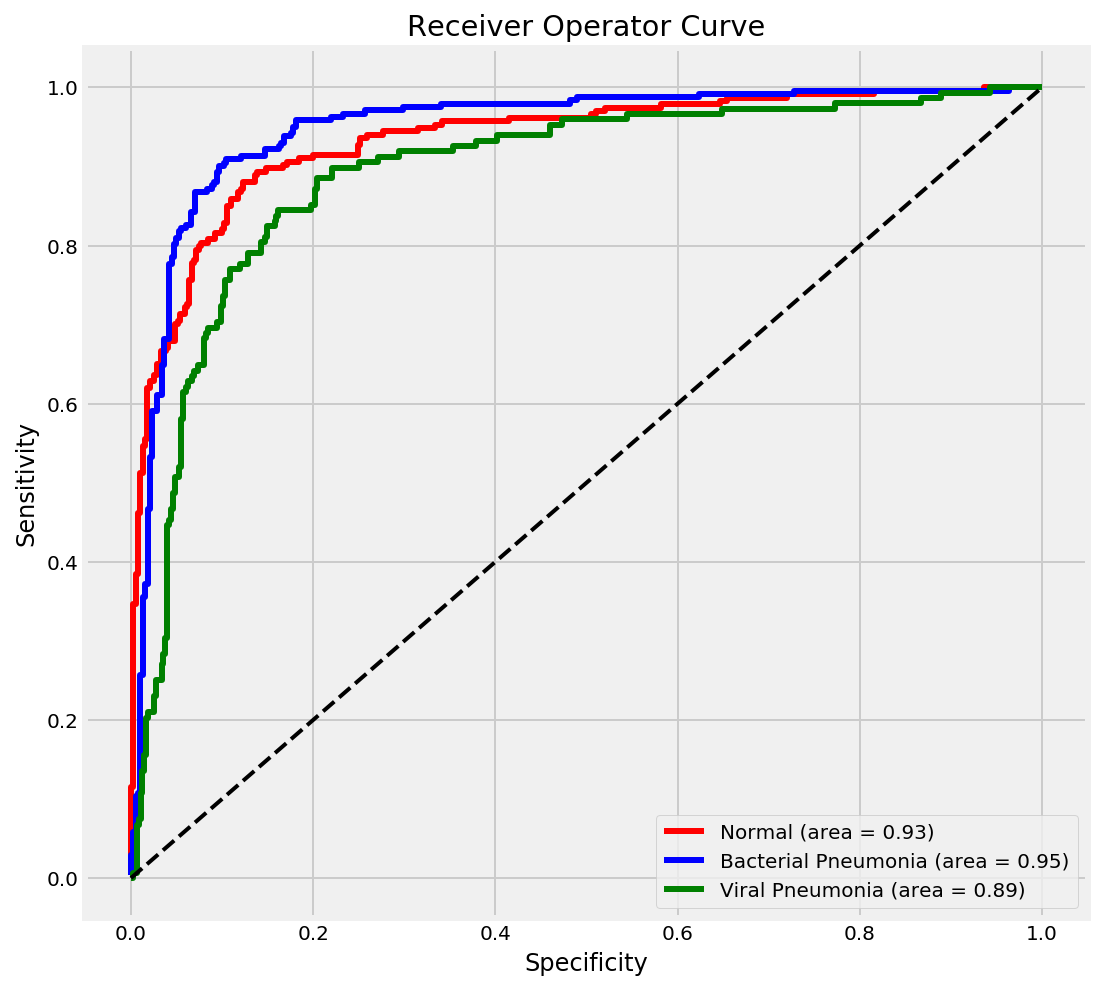

In [19]:
# Evaluate model 
auc_roc(model)

In [14]:
# Function to calculate classification metrics and plot the confusion matrix 
def confusion_metrics(model):
    # Create a heatmap confusion matrix - get predictions 
    if type(model) == Sequential:
        pred = model.predict_classes(X_test)
    elif type(model) == Model:
        pred = model.predict(X_test)
        pred = np.argmax(pred,axis=1)
    
    # Create confusion matrix 
    classes = ["Normal", 'Bacterial Pneumonia', 'Viral Pneumonia']
    cm  = metrics.confusion_matrix(test['label'], pred)
    cm_df = pd.DataFrame(cm, columns=classes)
    cm_df.index = classes

    # Plot matrix on heatmap 
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Calculate classification metrics 
    tn, fp1,fp2, fn1, tp1, tpf1, fn2, tpf2, tp2 = cm.ravel()
    precision = (tp1 + tp2) /(tp1 + tp2 + fp1 + fp2)
    sensitivity = (tp1 + tp2) /(tp1 + tp2 + fn1 + fn2)
    accuracy = (tp1 + tp2 + tn) / (tn + fp1 + fp2 + fn1 + tp1 + tpf1 + fn2 + tpf2 + tp2)
    specificity = tn / (tn + fp1 + fp2)
    
    print('Precision: ', precision)
    print('Sensitivity: ', sensitivity)
    print("Accuracy: ", accuracy)
    print('Specificity: ', specificity)

Precision:  0.7632743362831859
Sensitivity:  0.9857142857142858
Accuracy:  0.7564102564102564
Specificity:  0.5427350427350427


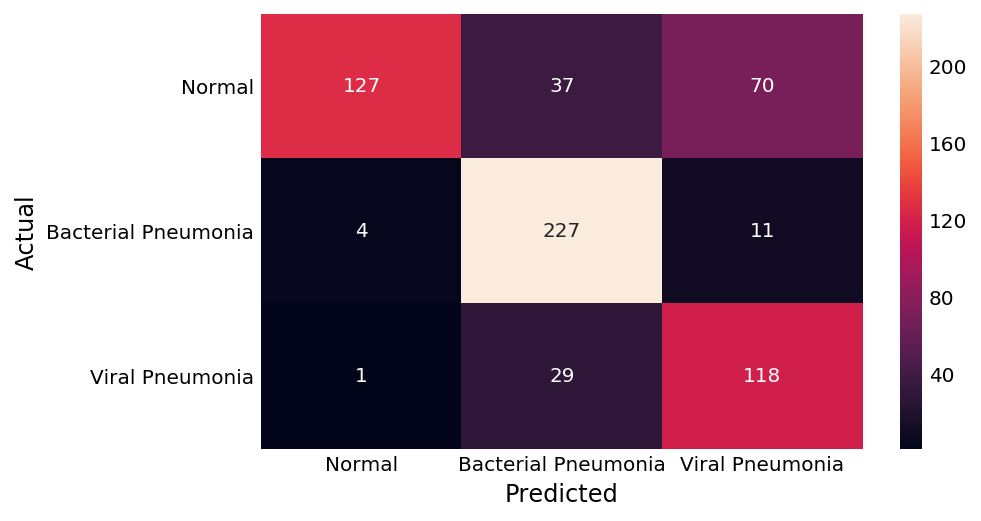

In [21]:
# Evaluate model 
confusion_metrics(model)

In [15]:
# Function to plot the train and test performance in the model per epoch 
def train_test_eval(history, batch_size):
    # Loss vs val_loss plot
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    
    # Acc vs val_acc plot
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    
    # Labels
    labels = ['Loss', 'Accuracy']
    for i in range(2):
        ax[i].set_title('Model ' + labels[i])
        ax[i].set_ylabel(labels[i])
        ax[i].set_xlabel('Epoch')
        ax[i].set_xticks(range(0,batch_size))
        ax[i].set_xticklabels(range(1,batch_size + 1))
        ax[i].legend(['Train', 'Test'], loc='best'); 

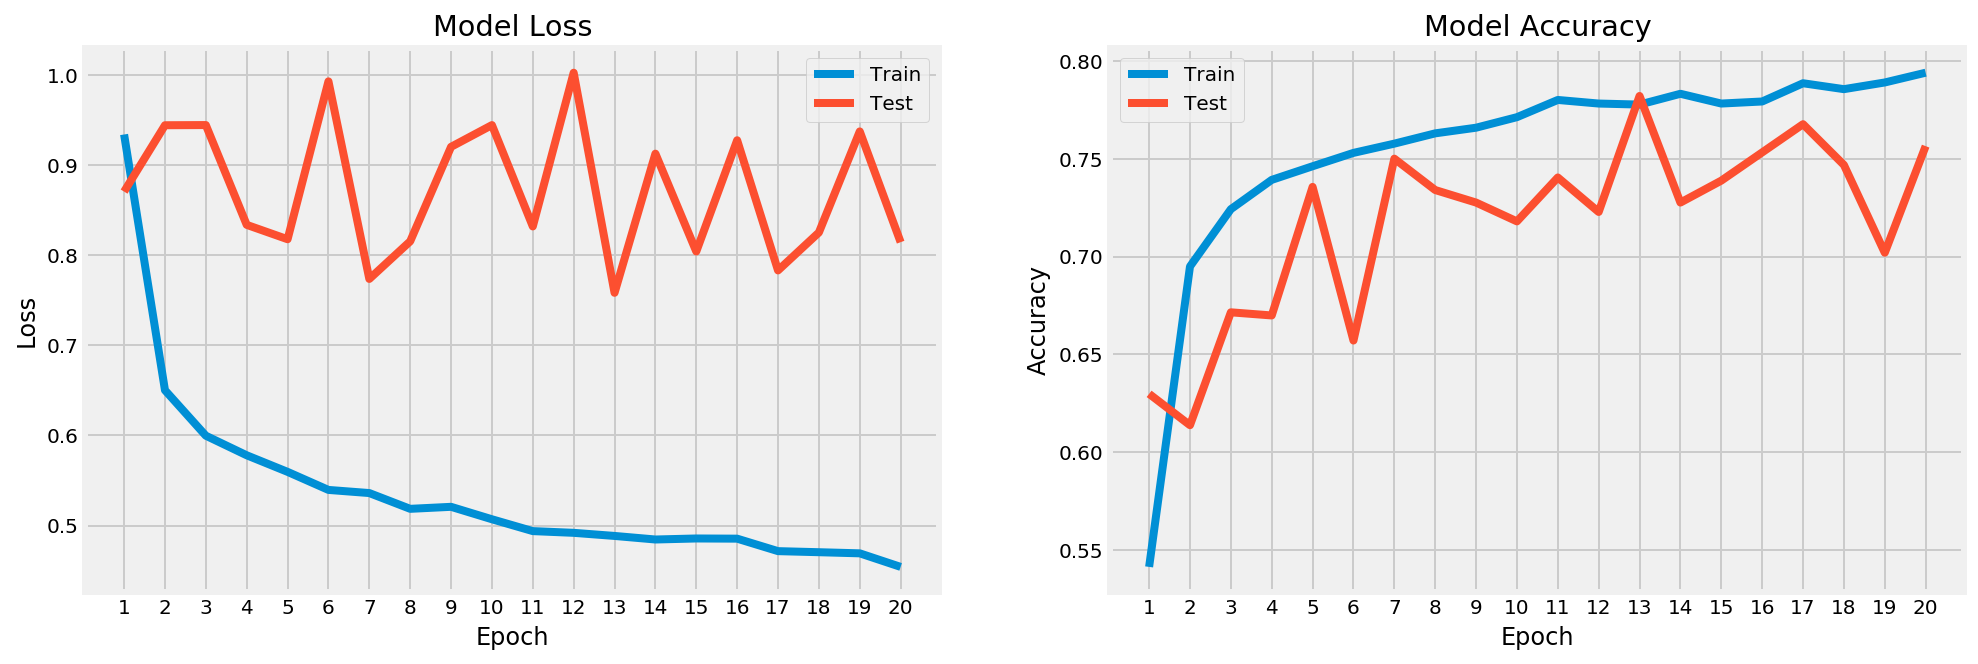

In [24]:
# Evaluate model 
train_test_eval(history, 20)

<a id='transfer'></a>
#### Transfer Learning VGG16 Model & Evaluation  
I used the same pretrained Keras VGG16 model as on my binary classification problem [3]. I modified the top layer to output 3 classes instead of 2. 

In [32]:
# Define VGG16 base model 
base = VGG16(weights = 'imagenet', include_top = False, input_shape = X_train.shape[1:])

# Use pretrained weights in base model
for layer in base.layers:
    layer.trainable = False

# Define top output layer 
vg_model = Sequential()
vg_model.add(base)
vg_model.add(Flatten())
vg_model.add(Dense(3, activation='softmax'))

# Compile model
vg_model.compile(Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Model summary 
vg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 75267     
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
# Fit model
history_vg = vg_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),epochs=10, 
                                  validation_data=(X_test, y_test))

Epoch 1/10
238/238 [==============================] - 83s 348ms/step - loss: 0.6793 - acc: 0.7058 - val_loss: 0.5574 - val_acc: 0.8413
Epoch 2/10
238/238 [==============================] - 79s 331ms/step - loss: 0.5066 - acc: 0.7763 - val_loss: 0.4906 - val_acc: 0.8574
Epoch 3/10
238/238 [==============================] - 79s 334ms/step - loss: 0.4675 - acc: 0.7951 - val_loss: 0.5328 - val_acc: 0.8285
Epoch 4/10
238/238 [==============================] - 79s 333ms/step - loss: 0.4423 - acc: 0.8064 - val_loss: 0.5582 - val_acc: 0.8237
Epoch 5/10
238/238 [==============================] - 79s 332ms/step - loss: 0.4254 - acc: 0.8163 - val_loss: 0.5953 - val_acc: 0.8045
Epoch 6/10
238/238 [==============================] - 80s 335ms/step - loss: 0.4099 - acc: 0.8182 - val_loss: 0.5635 - val_acc: 0.8221
Epoch 7/10
238/238 [==============================] - 79s 332ms/step - loss: 0.3932 - acc: 0.8350 - val_loss: 0.5782 - val_acc: 0.8317
Epoch 8/10
238/238 [==============================] - 8

AUC-ROC:  0.9499060473487649


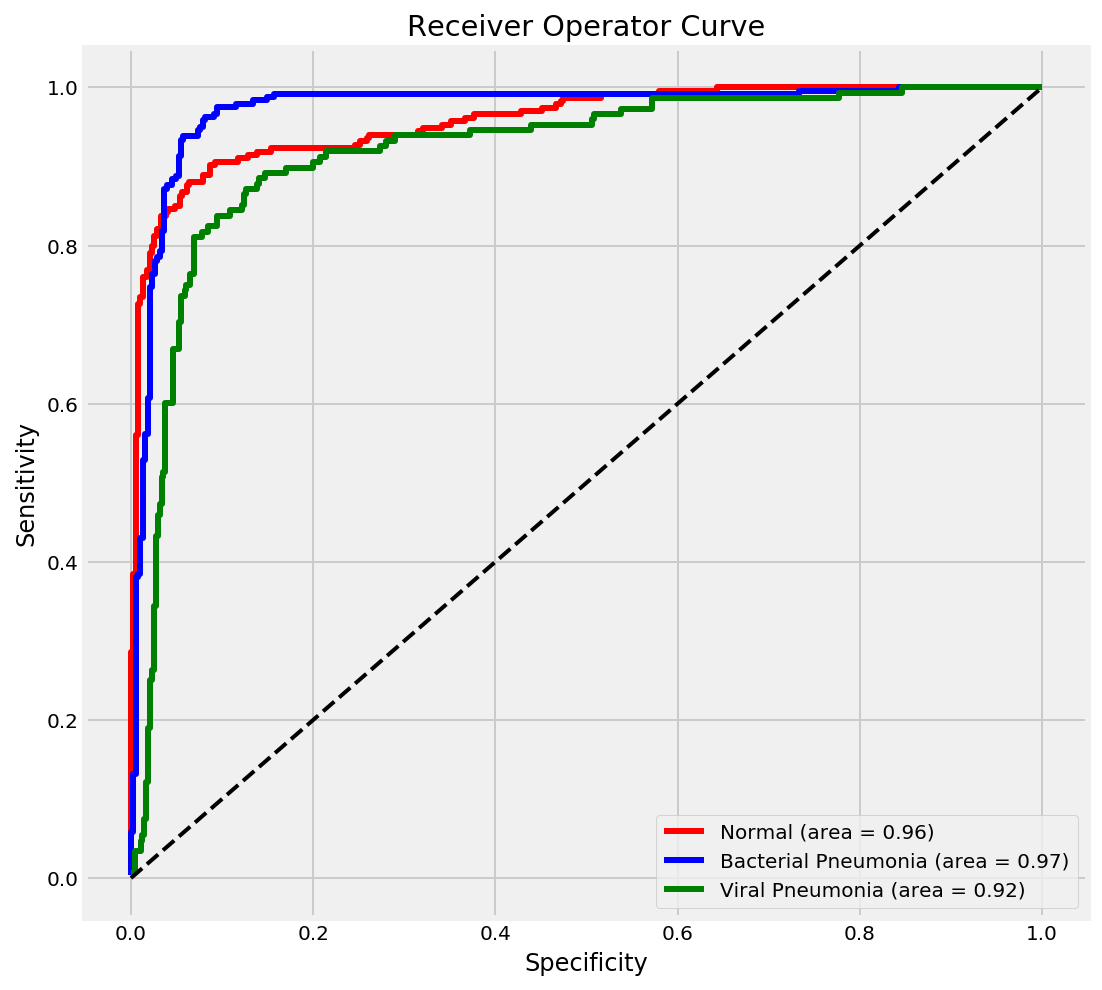

In [34]:
# Evaluate model 
auc_roc(vg_model)

Precision:  0.8192219679633868
Sensitivity:  0.9916897506925207
Accuracy:  0.8221153846153846
Specificity:  0.6623931623931624


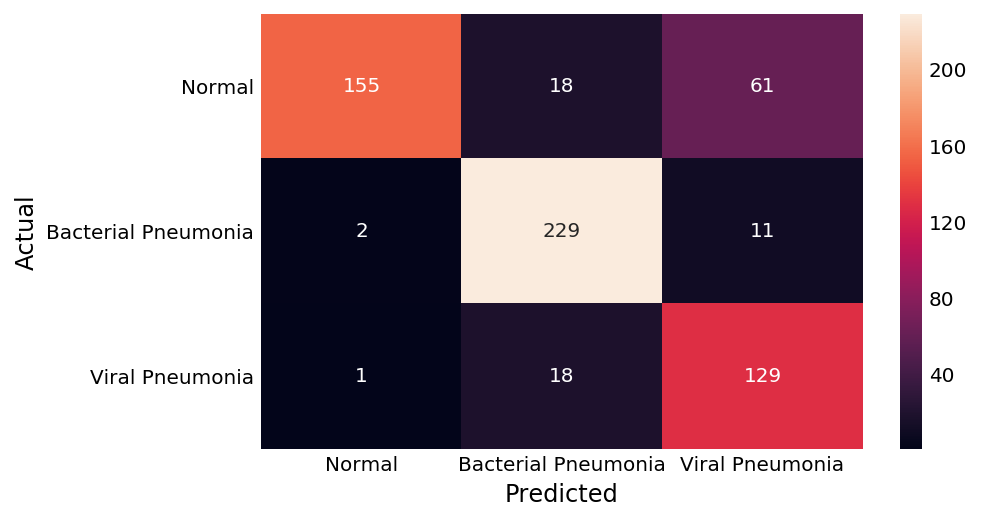

In [35]:
# Evaluate model 
confusion_metrics(vg_model)

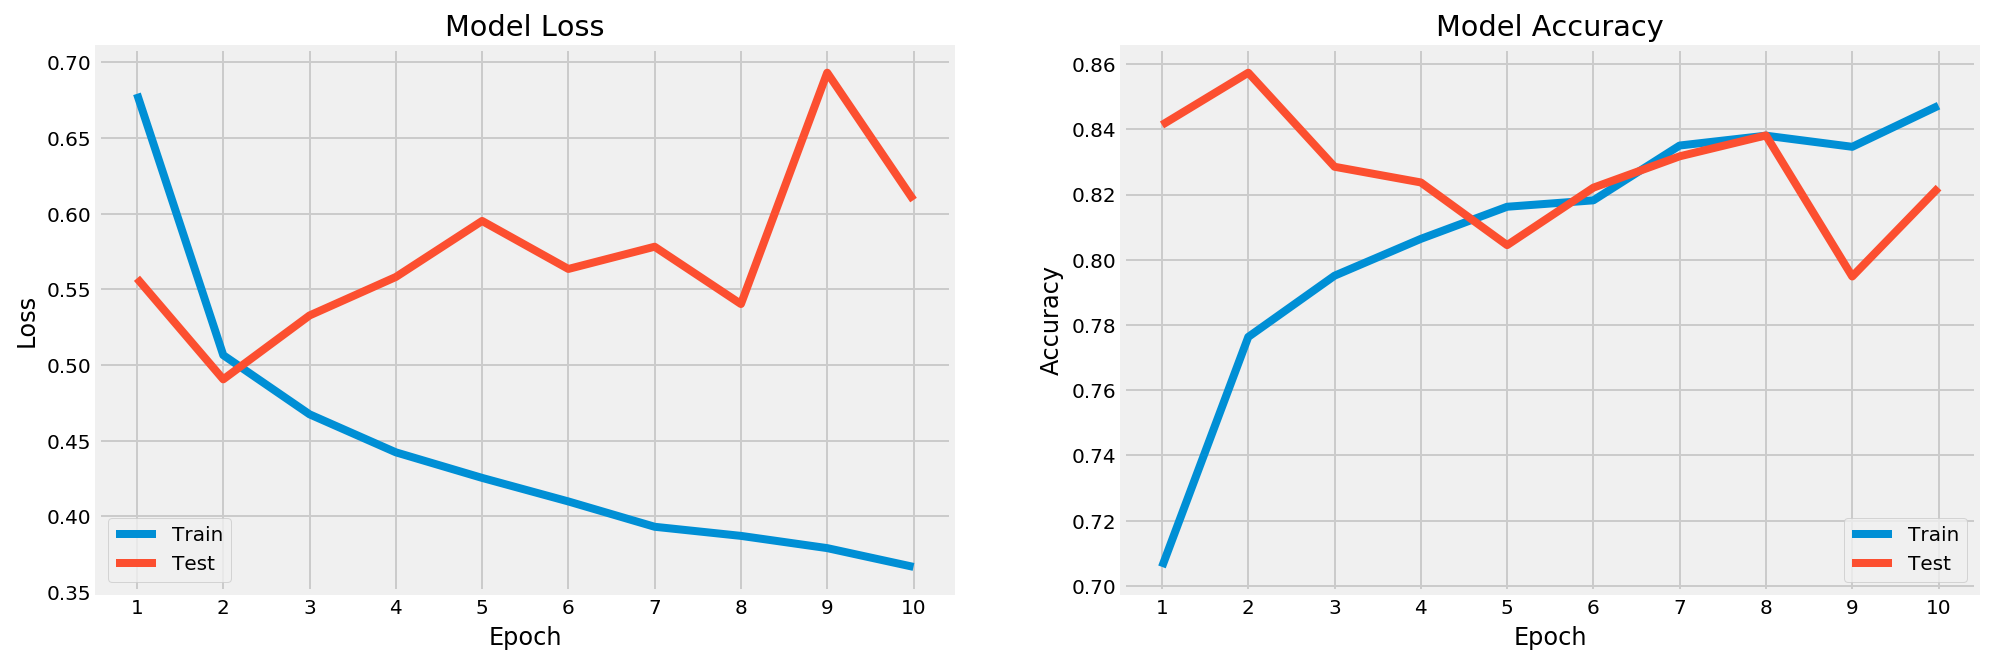

In [36]:
# Evaluate model 
train_test_eval(history_vg, 10)

<a id='transfer_2'></a>
#### Transfer Learning InceptionV3 Model & Evaluation  
I also performed transfer learning with the Keras InceptionV3 model. It is important to note that Kermany et al. did not test this 3 class problem, but instead looked at an additional binary classifiction of bacterial from viral pneumonia [2]. 

In [35]:
# Define InceptionV3 base model 
base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = X_train.shape[1:])

# Use pretrained weights in base model
for layer in base.layers:
    layer.trainable = False

# Define top output layer 
inception_model = Sequential()
inception_model.add(base)
inception_model.add(Flatten())
inception_model.add(Dense(3, activation='softmax'))

# Compile model
inception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])    

# Inspect InceptionV3 model architecture 
inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153603    
Total params: 21,956,387
Trainable params: 153,603
Non-trainable params: 21,802,784
_________________________________________________________________


In [36]:
# Fit model
history_inception = inception_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),epochs=10, 
                                  validation_data=(X_test, y_test))

Epoch 1/10
238/238 [==============================] - 94s 393ms/step - loss: 2.6223 - acc: 0.6539 - val_loss: 6.5330 - val_acc: 0.3349
Epoch 2/10
238/238 [==============================] - 79s 333ms/step - loss: 1.8970 - acc: 0.7066 - val_loss: 4.2799 - val_acc: 0.5737
Epoch 3/10
238/238 [==============================] - 78s 329ms/step - loss: 1.8531 - acc: 0.7339 - val_loss: 7.1335 - val_acc: 0.3365
Epoch 4/10
238/238 [==============================] - 79s 334ms/step - loss: 1.8130 - acc: 0.7436 - val_loss: 4.4097 - val_acc: 0.4631
Epoch 5/10
238/238 [==============================] - 79s 334ms/step - loss: 1.8350 - acc: 0.7480 - val_loss: 11.6404 - val_acc: 0.2452
Epoch 6/10
238/238 [==============================] - 80s 335ms/step - loss: 1.8938 - acc: 0.7626 - val_loss: 6.9607 - val_acc: 0.4231
Epoch 7/10
238/238 [==============================] - 79s 333ms/step - loss: 1.9932 - acc: 0.7603 - val_loss: 5.7594 - val_acc: 0.4567
Epoch 8/10
238/238 [==============================] - 

AUC-ROC:  0.7346897586554526


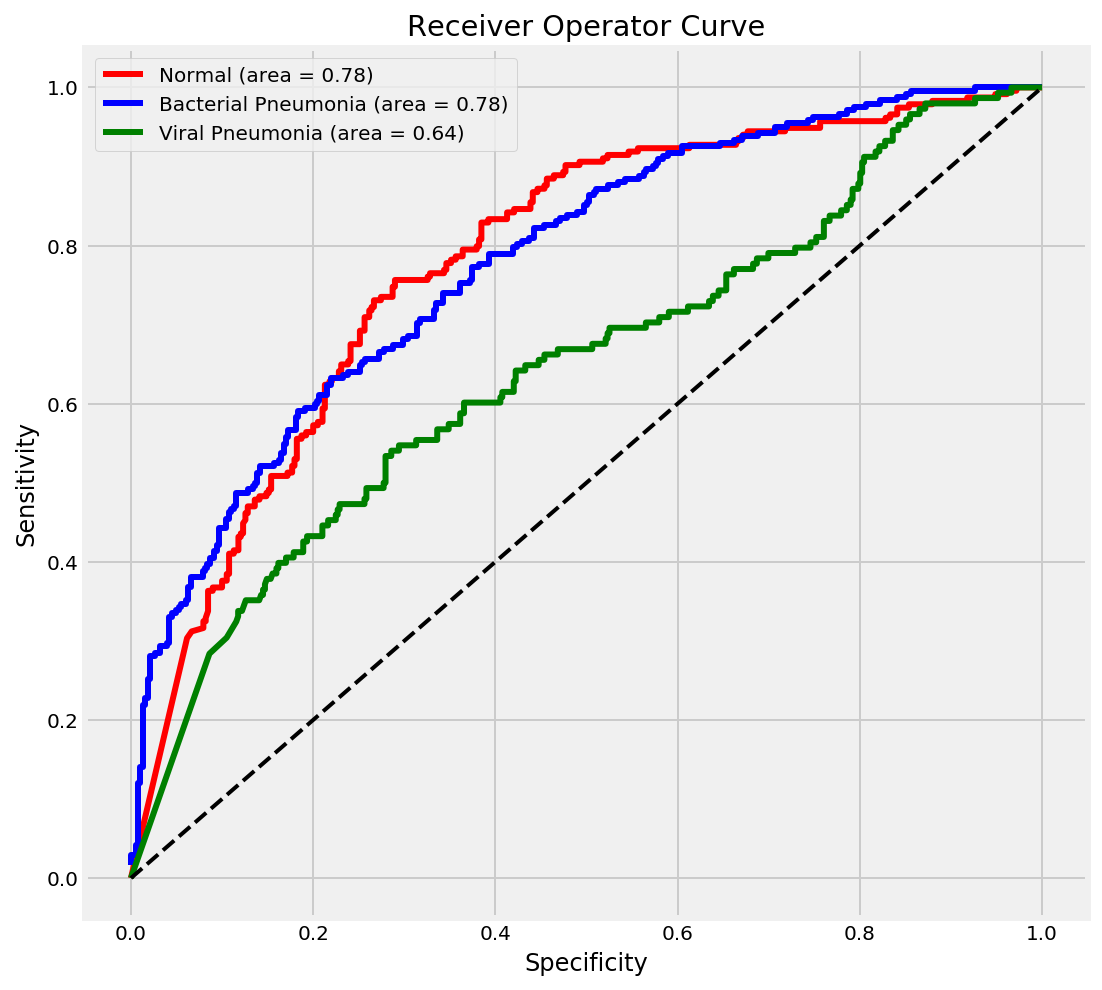

In [37]:
# Evaluate model 
auc_roc(inception_model)

Precision:  0.6884422110552764
Sensitivity:  0.556910569105691
Accuracy:  0.4951923076923077
Specificity:  0.7350427350427351


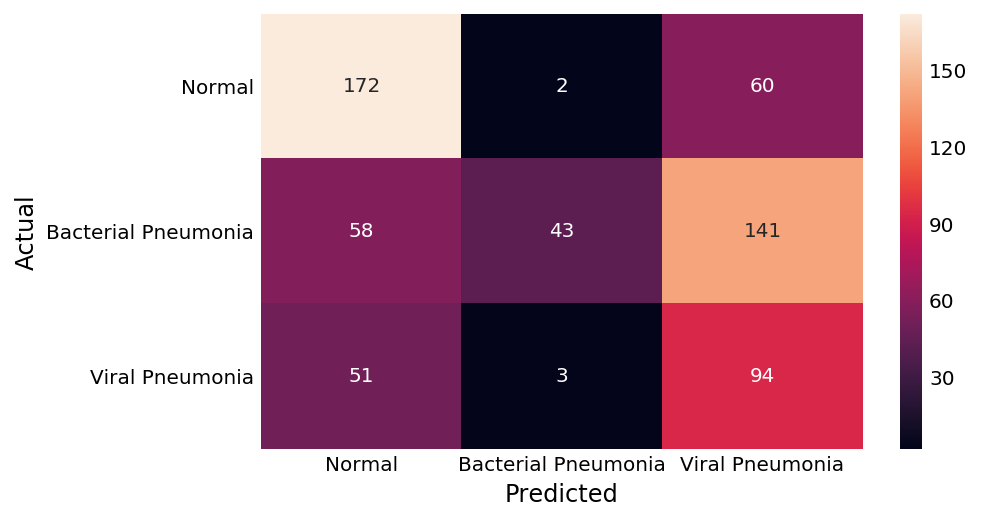

In [38]:
# Evaluate model 
confusion_metrics(inception_model)

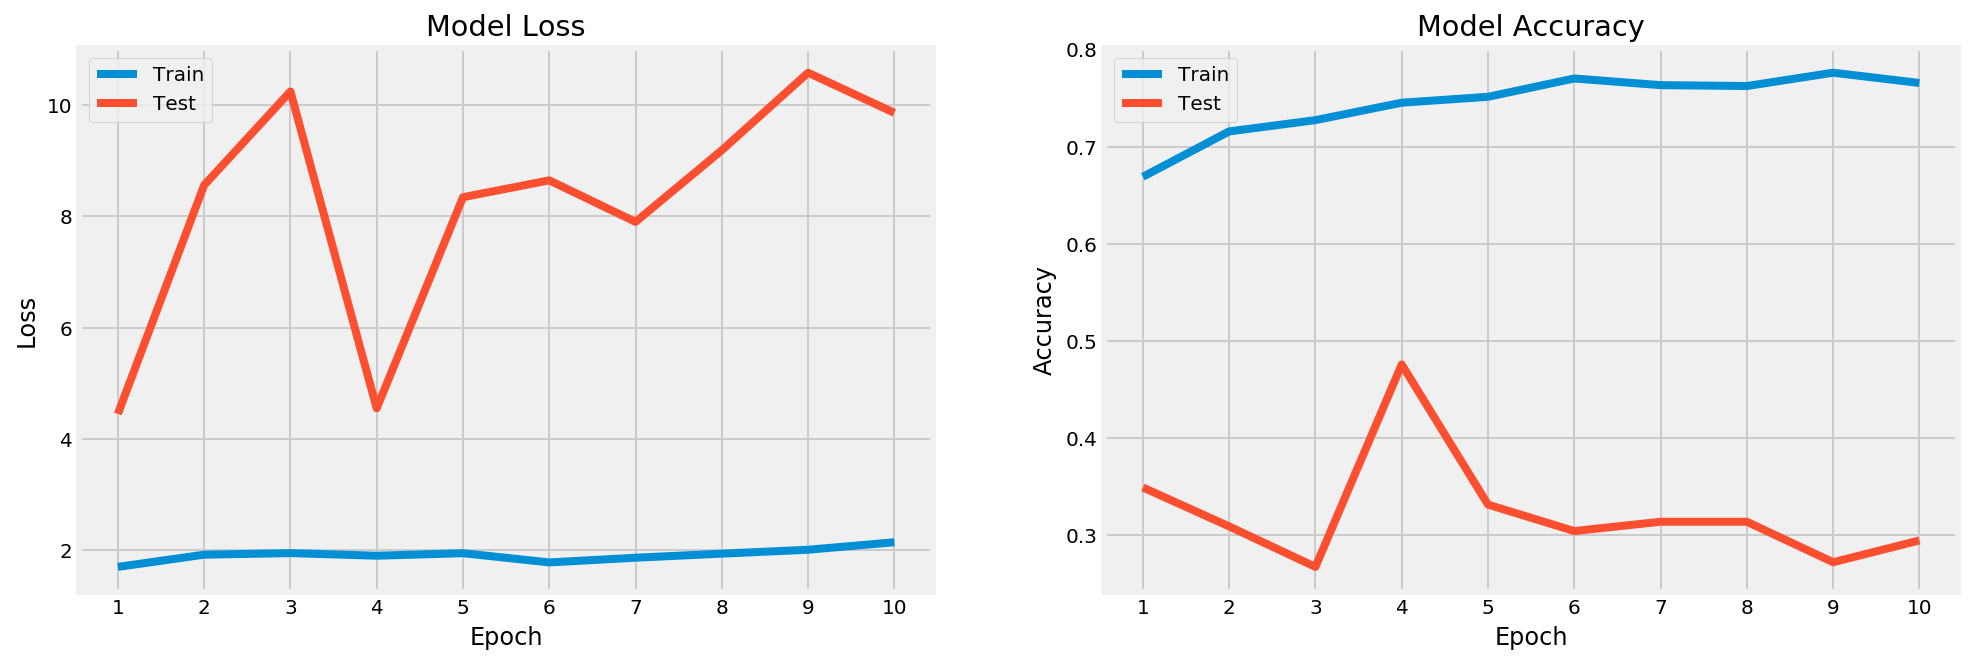

In [34]:
# Evaluate model 
train_test_eval(history_inception, 10)

<a id='conc'></a>
### Conclusions   

Much like the binary classification problem, these 3 models suffered from overfitting. My CNN model was the least overfit of the 3 due to its simple architecture, however, had slightly worse metrics than the VGG16 model. The InceptionV3 model was by far the worst of all 6 models. I suspect that it is much too complex for the problem at hand given the amount of data available. I would not recommend using transfer learning with InceptionV3 for this multi-class classification problem.  

The VGG16 model, while still overfit, has respectable results. It achieved a AUC-ROC score of 0.95 with 82% accuracy, 99% sensitivity, and 66% specificity. These results are almost comparable to those of human experts. When looking at the bacterial and viral cases, predictions for viral were almost always worse. I believe this has to do with the smaller dataset for viral. It would seem that oversampling is not sufficient.  

To conclude, I have also demonstrated that CNNs are appropriate for diagnosing multiple conditions with respectable results. 

<a id='next'></a>
### Next Steps  

In terms of next steps, I would like to further explore different transfer learning base models. Keras has a handful of models, such as Xception and VGG19 that could also yield positive results. In addition, I would like to reach out to the point of contact for the Kermany et al. study to get a copy of their code and understand how they achieved their results using the InceptionV3 model. I replicated my InceptionV3 model as best I could with the information provided in the paper, but would like to take a look at the actual code for more details.

Since my multi-class classification models were not quite as good at differentiating pneumonia cases, I would like to attempt another binary classification to properly distinguish bacterial from viral pneumonia. Additional data would most likely be required since there were only 1000+ viral images in the current dataset. 

------------------------------------
<a id='ref'></a>
**References**

[1] World Health Organization,"Fact Sheet: Pneumonia", (2016), http://www.who.int/en/news-room/fact-sheets/detail/pneumonia 
  
[2] Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X- Ray Images for Classification”, Mendeley Data, v2, http://dx.doi.org/10.17632/rscbjbr9sj.2  

[3] Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. 

[4] Fiore, David C. et al. "Antibiotic overperscribing: still a major concern." Journal of Family Practice 66.12 (2017). https://www.mdedge.com/sites/default/files/Document/November-2017/JFP06612730.PDF 
